In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import exp,log,argmax,argmin,ones,zeros,cos,sin,sqrt,dot,mean,std
from scipy.stats import norm
import scipy.linalg as la
import time
from scipy.special import gamma as Gamma

In [16]:
# Some important values
sigma=0.3
r=0.03  
T=0.25
K=40

In [2]:
# This monte-carlo simulation function, takes the range of strike price [K2,K1], 
# produces the option price based on a fixed S0
def surplus(a):
    if a>0:
        return a
    return 0
def MC_simulation_call(r,T,H,s0,sigma,K,n):#K1 is the minimum strike price, K2 is the maximum,
                                          #n is how many different strike prices total
    T_H=T**H
    mu_T=r*T-T_H*T_H*sigma*sigma/2
    return surplus(s0*exp(sigma*np.random.normal(0,T_H)+mu_T)-K) 

In [17]:
#finite difference method
def surplus(a):
    if a>0:
        return a
    return 0
def fd2_bvp(n,a,c,alpha,beta,gamma,alpha1,beta1,gamma1,alpha2,beta2,gamma2,f):
    h=(c-a)/n
    A=zeros((n+1,n+1))
    A[0][0]=2*h*alpha1-3*beta1
    A[0][1]=4*beta1
    A[0][2]=-beta1
    A[n][n-2]=beta2
    A[n][n-1]=-4*beta2
    A[n][n]=2*h*alpha2+3*beta2
    b=ones(n+1)
    b[0]=2*gamma1*h
    b[n]=2*h*gamma2
    for i in range(1,n):
        A[i][i-1]=2*gamma-beta*h
        A[i][i]=2*h*h*alpha-4*gamma
        A[i][i+1]=beta*h+2*gamma
        b[i]=2*h*h*f[i]
    (P,L,U)=la.lu(A)
    b=dot(b,P)
    y=ones(n+1)
    y[0]=b[0]
    for i in range(1,n+1):
        for j in range(0,i):
            b[i]-=L[i][j]*y[j]
        y[i]=b[i]
    solu=ones(n+1)
    solu[n]=y[n]/U[n][n]
    for i in range(n-1,-1,-1):
        for j in range(i+1,n+1):
            y[i]-=U[i][j]*solu[j]
        solu[i]=y[i]/U[i][i]

    return solu

In [18]:
# this function returns a value for fractional pde at time t(n-1), tomorrow
def fractional_be(N,M,r,T,alpha,xm,sigma,k):  
    x=np.arange(-xm, xm+xm/N, 2*xm/N)
    v=np.array([k*exp(x[i])-k if k*exp(x[i])-k>0 else 0 for i in range(len(x))])
    h=(T-0)/M
    v_list=[v]
    for j in range(1,M):
        t=j*h
        lambda1=Gamma(1+alpha)  
        lambda2=((T-t)**(1-alpha))/(Gamma(2-alpha))
        lambda3=((T-t)**(1-alpha))*(t**(alpha-1))
        D=(sigma*sigma/2)*lambda1
        E=(lambda2*r-lambda1*sigma*sigma/2)
        F=-r*lambda2-rho(h,alpha)*lambda3
        gamma2=k*(-exp(-r*t)+exp(xm))
        v=fd2_bvp(N,-xm,xm,F,E,D,1,0,0,1,0,gamma2,lambda3*v_cumulated(v_list,h,alpha))
        v_list+=[np.array(v)]
#     return (v_list[0],v_list[1],v_list[2])
    return v
def w(j,alpha):
    return (j+1)**(1-alpha)-j**(1-alpha)
def rho(h,alpha):
    return 1/(Gamma(2-alpha)*(h**alpha))
def v_cumulated(v_list,h,alpha):
    idx_n=len(v_list)
    result=-rho(h,alpha)*(w(idx_n-1,alpha)*v_list[0])
    for j in range(1,idx_n):
        result+=rho(h,alpha)*(w(idx_n-j,alpha)-w(idx_n-1-j,alpha))*v_list[j]
    return result 

In [19]:
def fdm_be_call(N,M,r,T,H,xm,sigma,k):
    x=np.arange(-xm,xm+xm/N,2*xm/N)
    v=np.array([k*exp(x[i])-k if k*exp(x[i])-k>0 else 0 for i in range(len(x))])
    h=(T-0)/M
    F=-r
    sigma_H=sigma*sigma*H*h**(2*H-1)
    param=2*H-1
    v_list=[v]
    for j in range(1,M+1):
        t=j*h
        D=sigma_H*j**param
        E=r-sigma_H*j**param
        gamma1=0
        gamma2=k*(-exp(-r*t)+exp(xm))
        v=fd2_bvp(N,-xm,xm,1-h*F,-h*E,-h*D,1,0,gamma1,1,0,gamma2,v)
        v_list+=[v]
    return v
def fdm_be_put(N,M,r,T,H,xm,sigma,k):
    x=np.arange(-xm,xm+xm/N,2*xm/N)
    v=np.array([k-k*exp(x[i]) if k-k*exp(x[i])>0 else 0 for i in range(len(x))])
    h=(T-0)/M
    F=-r
    sigma_H=sigma*sigma*H*h**(2*H-1)
    param=2*H-1
    v_list=[v]
    for j in range(1,M+1):
        t=j*h
        D=sigma_H*j**param
        E=r-sigma_H*j**param
        gamma1=k*(exp(-r*t)-exp(-xm))
        gamma2=0
        v=fd2_bvp(N,-xm,xm,1-h*F,-h*E,-h*D,1,0,gamma1,1,0,gamma2,v)
        v_list+=[v]
    return v

In [20]:
# all these _list functions return a list of v over time t instead of the final step
def fractional_be_list(N,M,r,T,alpha,xm,sigma,k):  
    x=np.arange(-xm, xm+xm/N, 2*xm/N)
    v=np.array([k*exp(x[i])-k if k*exp(x[i])-k>0 else 0 for i in range(len(x))])
    h=(T-0)/M
    v_list=[v]
    for j in range(1,M):
        t=j*h
        lambda1=Gamma(1+alpha)  
        lambda2=((T-t)**(1-alpha))/(Gamma(2-alpha))
        lambda3=((T-t)**(1-alpha))*(t**(alpha-1))
        D=(sigma*sigma/2)*lambda1
        E=(lambda2*r-lambda1*sigma*sigma/2)
        F=-r*lambda2-rho(h,alpha)*lambda3
        gamma2=k*(-exp(-r*t)+exp(xm))
        v=fd2_bvp(N,-xm,xm,F,E,D,1,0,0,1,0,gamma2,lambda3*v_cumulated(v_list,h,alpha))
        v_list+=[np.array(v)]
    return v_list

def fdm_be_list(N,M,r,T,H,xm,sigma,k):
    x=np.arange(-xm,xm+xm/N,2*xm/N)
    v=np.array([k*exp(x[i])-k if k*exp(x[i])-k>0 else 0 for i in range(len(x))])
    h=(T-0)/M
    F=-r
    sigma_H=sigma*sigma*H*h**(2*H-1)
    param=2*H-1
    v_list=[v]
    for j in range(1,M+1):
        D=sigma_H*j**param
        E=r-sigma_H*j**param
        gamma2=k*(-exp(-r*j*h)+exp(xm))
        v=fd2_bvp(N,-xm,xm,1-h*F,-h*E,-h*D,1,0,0,1,0,gamma2,v)
        v_list+=[v]
    return v_list


In [21]:
def call_option_explicit(r,T,H,s0,sigma,strike):
    T_H=T**(H)                                        
    d1=(log(s0/strike)+r*T+1/2*sigma*sigma*T_H*T_H)/(sigma*T_H)
    d2=d1-sigma*T_H
    return s0*norm.cdf(d1)-strike*exp(-r*T)*norm.cdf(d2)

def put_option_explicit(r,T,H,s0,sigma,strike):
    T_H=T**(H)                                        
    d1=(log(s0/strike)+r*T+1/2*sigma*sigma*T_H*T_H)/(sigma*T_H)
    d2=d1-sigma*T_H          #this is a put option
    return -s0*norm.cdf(-d1)+strike*exp(-r*T)*norm.cdf(-d2)

def call_delta_explicit(r,T,H,s0,sigma,strike):
    T_H=T**(H)                                        #some important parameters
    d1=(log(s0/strike)+r*T+1/2*sigma*sigma*T_H*T_H)/(sigma*T_H)
    return norm.cdf(d1)

def put_delta_explicit(r,T,H,s0,sigma,strike):
    T_H=T**(H)                                        #some important parameters
    d1=(log(s0/strike)+r*T+1/2*sigma*sigma*T_H*T_H)/(sigma*T_H)
    return norm.cdf(d1)-1

In [22]:
# This funciton follows prof Chen's instruction to get the today's price for Jumarie's formula
def fractional_call(N,M,r,T,alpha,xm,sigma,k):  
    x=np.arange(-xm, xm+xm/N, 2*xm/N)
    v=np.array([k*exp(x[i])-k if k*exp(x[i])-k>0 else 0 for i in range(len(x))])
    h=(T-0)/M
    v_list=[v]
    for j in range(1,M):
        t=j*h
        lambda1=Gamma(1+alpha)  
        lambda2=((T-t)**(1-alpha))/(Gamma(2-alpha))
        lambda3=((T-t)**(1-alpha))*(t**(alpha-1))
        D=(sigma*sigma/2)*lambda1
        E=(lambda2*r-lambda1*sigma*sigma/2)
        F=-r*lambda2-rho(h,alpha)*lambda3
        gamma1=0
        gamma2=k*(-exp(-r*t)+exp(xm))
        v=fd2_bvp(N,-xm,xm,F,E,D,1,0,gamma1,1,0,gamma2,lambda3*v_cumulated(v_list,h,alpha))
        v_list+=[np.array(v)]
    v=v+(h**(1-alpha))*((T-h)**(alpha-1))*v_cumulated_today(v_list,h,alpha)
    return v


def fractional_put(N,M,r,T,alpha,xm,sigma,k):  
    x=np.arange(-xm, xm+xm/N, 2*xm/N)
    v=np.array([k-k*exp(x[i]) if k-k*exp(x[i])>0 else 0 for i in range(len(x))])
    h=(T-0)/M
    v_list=[v]
    for j in range(1,M):
        t=j*h
        lambda1=Gamma(1+alpha)  
        lambda2=((T-t)**(1-alpha))/(Gamma(2-alpha))
        lambda3=((T-t)**(1-alpha))*(t**(alpha-1))
        D=(sigma*sigma/2)*lambda1
        E=(lambda2*r-lambda1*sigma*sigma/2)
        F=-r*lambda2-rho(h,alpha)*lambda3
        gamma1=k*(exp(-r*t)-exp(-xm))
        gamma2=0
        v=fd2_bvp(N,-xm,xm,F,E,D,1,0,gamma1,1,0,gamma2,lambda3*v_cumulated(v_list,h,alpha))
        v_list+=[np.array(v)]
    v=v+(h**(1-alpha))*((T-h)**(alpha-1))*v_cumulated_today(v_list,h,alpha)
    return v


def v_cumulated_today(v_list,h,alpha):
    idx_n=len(v_list)
    result=-(w(idx_n-1,alpha)*v_list[0])+w(0,alpha)*v_list[-1]
    for j in range(1,idx_n):
        result+=(w(idx_n-j,alpha)-w(idx_n-1-j,alpha))*v_list[j]
    return result 



In [23]:
# These two monte-carlo simulation functions, takes the range of strike price [K2,K1], 
# produces the option price based on a fixed S0
def MC_simulation_call(r,T,H,s0,sigma,K2,K1,n):#K1 is the minimum strike price, K2 is the maximum,
                                          #n is how many different strike prices total
    T_H=T**H
    mu_T=r*T-T_H*T_H*sigma*sigma/2
    K_list=[K1+i/(n-1)*(K2-K1) for i in range(n)]
    return np.array([surplus(s0*exp(sigma*np.random.normal(0,T_H)+mu_T)-K_list[i]) for i in range(n)])


def MC_simulation_put(r,T,H,s0,sigma,K2,K1,n):#K1 is the minimum strike price, K2 is the maximum,
                                          #n is how many different strike prices total
    T_H=T**H
    mu_T=r*T-T_H*T_H*sigma*sigma/2
    K_list=[K1+i/(n-1)*(K2-K1) for i in range(n)]
    return np.array([surplus(-s0*exp(sigma*np.random.normal(0,T_H)+mu_T)+K_list[i]) for i in range(n)])


# This monte-carlo simulation, takes in a list of strike price "K_list", produces the option price based on a fixed S0
def MC_simulation_call_list(r,T,H,s0,sigma,K_list):
    T_H=T**H
    mu_T=r*T-T_H*T_H*sigma*sigma/2
    return np.array([surplus(s0*exp(sigma*np.random.normal(0,T_H)+mu_T)-K_list[i])for i in range(len(K_list))])

def MC_simulation_put_list(r,T,H,s0,sigma,K_list):
    T_H=T**H
    mu_T=r*T-T_H*T_H*sigma*sigma/2
    return np.array([surplus(-s0*exp(sigma*np.random.normal(0,T_H)+mu_T)+K_list[i])for i in range(len(K_list))])

In [24]:
# This is the function using the hu_oksendal explicit formula as the pricing method 
# to solve for implied vol for calls with different strikes
# p is the option price
def call_vol_solver_explicit(N,M,r,T,H,S,k,p):
    sigma0=0.1
    sigma1=0.3
    S=40
    f0=call_option_explicit(r,T,H,S,sigma0,k)-p
    f1=call_option_explicit(r,T,H,S,sigma1,k)-p
    trial=0
    while(trial<10):
        trial+=1
        temp=sigma1
#         print(f0,f1)
        sigma1=sigma1-(f1)*(sigma1-sigma0)/(f1-f0)
        sigma0=temp
        f0=f1
        f1=call_option_explicit(r,T,H,S,sigma1,k)-p
#         print("this is sigma1",sigma1,"this is value",f1)
        if abs(f1)<0.01:
            return sigma1
    return -1
        

# This is the function using the hu_oksendal explicit formula as the pricing method 
# to solve for implied vol for puts with different strikes
def put_vol_solver_explicit(N,M,r,T,H,S,k,p):
    sigma0=0.1
    sigma1=0.3
    S=40
    f0=put_option_explicit(r,T,H,S,sigma0,k)-p
    f1=put_option_explicit(r,T,H,S,sigma1,k)-p
    trial=0
    while(trial<10):
        trial+=1
        temp=sigma1
#         print(f0,f1)
        sigma1=sigma1-(f1)*(sigma1-sigma0)/(f1-f0)
        sigma0=temp
        f0=f1
        f1=put_option_explicit(r,T,H,S,sigma1,k)-p
#         print("this is sigma1",sigma1,"this is value",f1)
        if abs(f1)<0.01:
            return sigma1
    return -1
        


# This is the function using the hu_oksendal pde as the pricing method to solve for implied vol for calls with different strikes
# when we plot the implied vol vs strike price, we fix the price S and keep changing k
# That is for a specific xm range which is fixed to be 0.7,xm at with different strike price keeps moving forward as k increases
# the forward movement of xm is reflected in the increasing of idx
# so the idx indicates the value of xm at each strike price
def call_vol_solver_pde(N,M,r,T,H,xm,k,p,idx):
    sigma0=0.1
    sigma1=0.3
    S=40
    f0=fdm_be_call(N,M,r,T,H,xm,sigma0,k)[idx]-p
    f1=fdm_be_call(N,M,r,T,H,xm,sigma1,k)[idx]-p
    trial=0
    while(trial<5):
        temp=sigma1
        sigma1=sigma1-(f1)*(sigma1-sigma0)/(f1-f0)
        
#         print(f1,f0)
        sigma0=temp
        f0=f1
        f1=fdm_be_call(N,M,r,T,H,xm,sigma1,k)[idx]-p

        if abs(f1)<0.01:
            return sigma1
    return -1
# call_vol_solver_pde(100,100,0.03,0.25,0.75,1.5,40,1,50)     

# This is the function using the hu_oksendal pde as the pricing method to solve for implied vol for puts with different strikes
def put_vol_solver_pde(N,M,r,T,H,xm,k,p,idx):
    sigma0=0.1
    sigma1=0.3
    S=40
    f0=fdm_be_put(N,M,r,T,H,xm,sigma0,k)[idx]-p
    f1=fdm_be_put(N,M,r,T,H,xm,sigma1,k)[idx]-p
    trial=0
    while(trial<5):
        temp=sigma1
        sigma1=sigma1-(f1)*(sigma1-sigma0)/(f1-f0)
        
#         print(f1,f0)
        sigma0=temp
        f0=f1
        f1=fdm_be_put(N,M,r,T,H,xm,sigma1,k)[idx]-p

        if abs(f1)<0.01:
            return sigma1
    return -1
# put_vol_solver_pde(100,100,0.03,0.25,0.75,1.5,40,1,50)     

# This is the function using the jumerie pde as the pricing method to solve for implied vol for calls with different strikes
def call_vol_solver_fpde(N,M,r,T,H,xm,k,p,idx):
    sigma0=0.1
    sigma1=0.3
    S=40
    f0=fractional_call(N,M,r,T,H,xm,sigma0,k)[idx]-p
    f1=fractional_call(N,M,r,T,H,xm,sigma1,k)[idx]-p
    trial=0
    while(trial<5):
        temp=sigma1
        sigma1=sigma1-(f1)*(sigma1-sigma0)/(f1-f0)
        
#         print(f1,f0)
        sigma0=temp
        f0=f1
        f1=fractional_call(N,M,r,T,H,xm,sigma1,k)[idx]-p

        if abs(f1)<0.01:
            return sigma1
    return -1
# call_vol_solver_fpde(100,100,0.03,0.25,0.75,1.5,40,1,50)     

# This is the function using the jumerie pde as the pricing method to solve for implied vol for puts with different strikes
def put_vol_solver_fpde(N,M,r,T,H,xm,k,p,idx):
    sigma0=0.1
    sigma1=0.3
    S=40
    f0=fractional_put(N,M,r,T,H,xm,sigma0,k)[idx]-p
    f1=fractional_put(N,M,r,T,H,xm,sigma1,k)[idx]-p
    trial=0
    while(trial<5):
        temp=sigma1
        sigma1=sigma1-(f1)*(sigma1-sigma0)/(f1-f0)
        
#         print(f1,f0)
        sigma0=temp
        f0=f1
        f1=fractional_put(N,M,r,T,H,xm,sigma1,k)[idx]-p

        if abs(f1)<0.01:
            return sigma1
    return -1
# put_vol_solver_fpde(100,100,0.03,0.25,0.75,1.5,40,1,50)     


According to the explicit formula, put-call parity is still the same as standard BS
C-P=S-exp(-r*t)*K

0.298877807234458
0.29887780723446156


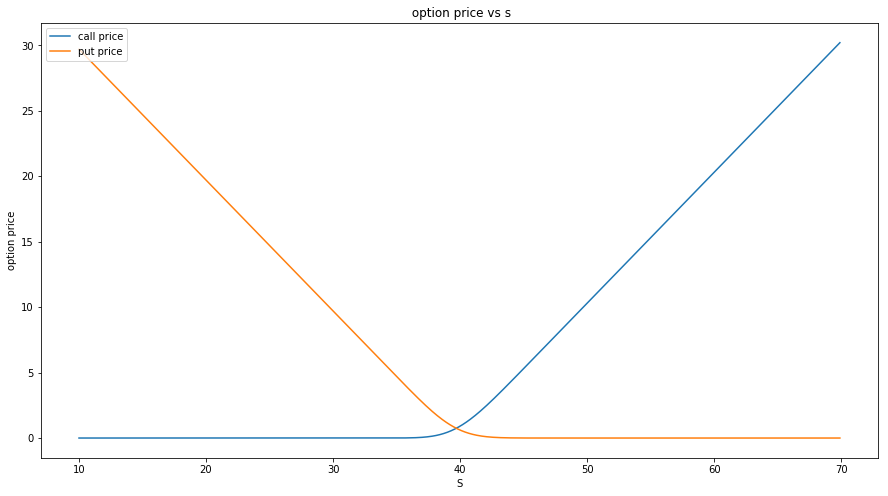

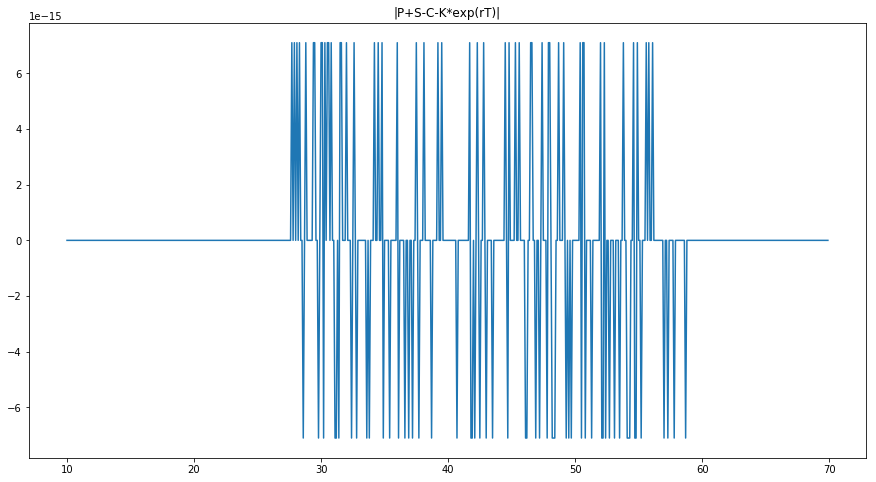

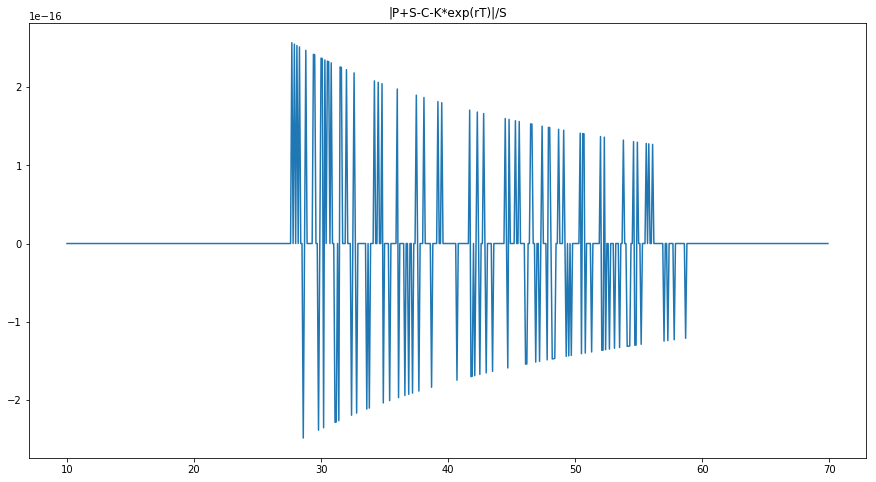

In [134]:
# We are going to check it by calculating P+S-C-exp(rt)*K to see if it is close to 0
S=40
p=put_option_explicit(0.03,0.25,0.75,S,0.3,40) 
c=call_option_explicit(0.03,0.25,0.75,S,0.3,40)
print(c-p)
print(S-K*(exp(-r*T)))
S_list=[S/10 for S in range(100,700)]
# S from 30.0 to 50.0

call_list=[call_option_explicit(r,0.25,0.75,S,sigma,40) for S in S_list]
put_list=[put_option_explicit(r,0.25,0.75,S,sigma,40) for S in S_list]
plt.figure(figsize=(15,8))
plt.title(" option price vs s")
plt.xlabel('S')
plt.ylabel('option price')
putcall_parity0=np.array(put_list)+np.array(S_list)-np.array(call_list)-exp(-r*T)*40
plt.plot(S_list,call_list,label='call price')
plt.plot(S_list,put_list,label='put price')
plt.legend(loc='upper left') 
plt.show()

# This is the error plot
plt.figure(figsize=(15,8))
plt.title('P+S-C-K*exp(rT)')
plt.plot(S_list,putcall_parity0)
plt.show()

# This is percentage error (relative to s)
plt.figure(figsize=(15,8))
plt.title('P+S-C-K*exp(rT)/S')
plt.plot(S_list,putcall_parity0/np.array(S_list))
plt.show()

0.29887780723446156
0.29887780723446156


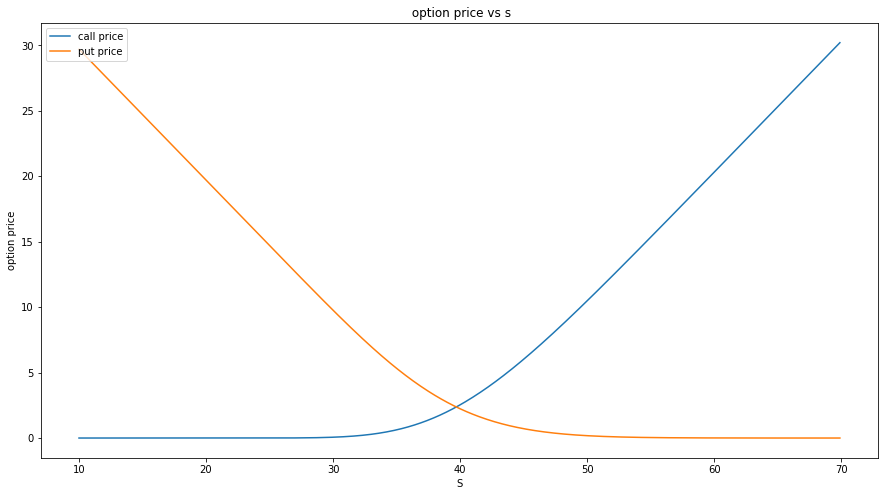

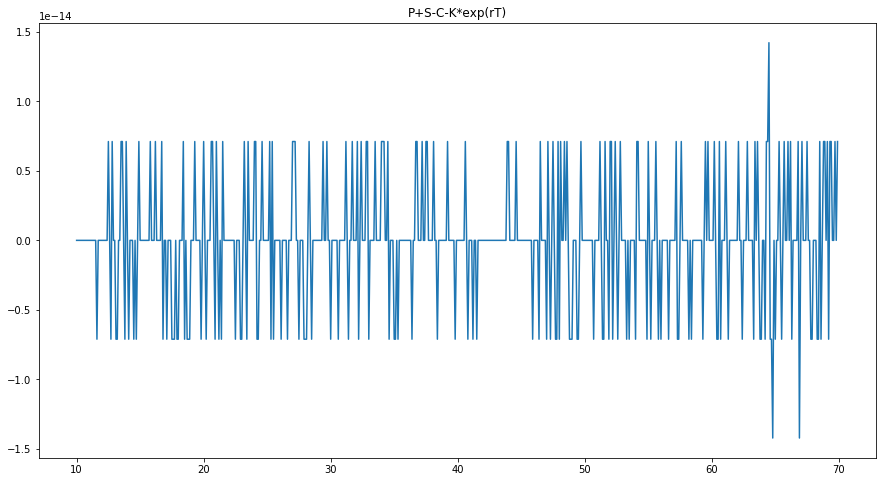

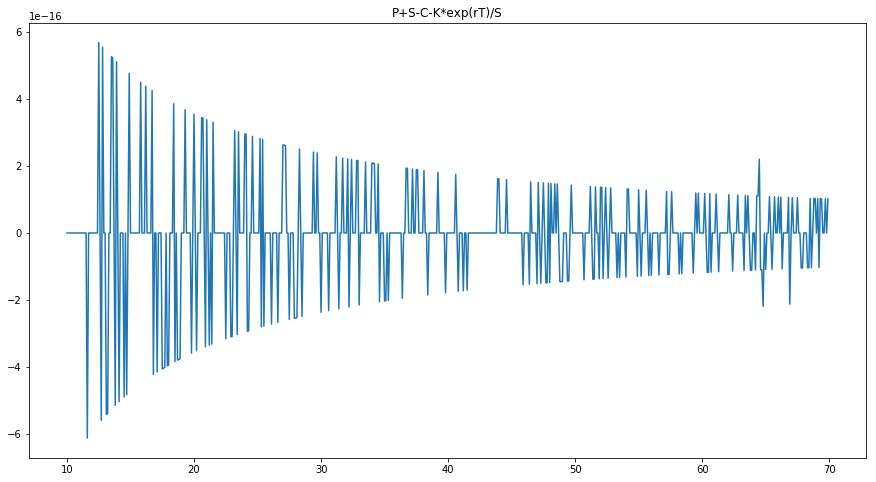

In [12]:
# We are going to check it by calculating P+S-C-exp(rt)*K to see if it is close to 0
# here is the standard BM put call parity using explicit formula
S=40
p=put_option_explicit(0.03,0.25,0.5,S,0.3,40) 
c=call_option_explicit(0.03,0.25,0.5,S,0.3,40)
print(c-p)
print(S-K*(exp(-r*T)))
S_list=[S/10 for S in range(100,700)]
# S from 30.0 to 50.0

call_list=[call_option_explicit(r,0.25,0.5,S,sigma,40) for S in S_list]
put_list=[put_option_explicit(r,0.25,0.5,S,sigma,40) for S in S_list]
plt.figure(figsize=(15,8))
plt.title(" option price vs s")
plt.xlabel('S')
plt.ylabel('option price')
putcall_parity0=np.array(put_list)+np.array(S_list)-np.array(call_list)-exp(-r*T)*40
plt.plot(S_list,call_list,label='call price')
plt.plot(S_list,put_list,label='put price')
plt.legend(loc='upper left') 
plt.show()

# This is the error plot
plt.figure(figsize=(15,8))
plt.title('P+S-C-K*exp(rT)')
plt.plot(S_list,putcall_parity0)
plt.show()

# This is percentage error (relative to s)
plt.figure(figsize=(15,8))
plt.title('P+S-C-K*exp(rT)/S')
plt.plot(S_list,putcall_parity0/np.array(S_list))
plt.show()

Now let's check the put-call parity from pde
1. the regular pde
2. the fractional pde

We only need to change the boundary condition of PDE
V(-Xm,t)=K*exp(-r*T)-K*exp(-Xm),V(Xm,t)=0

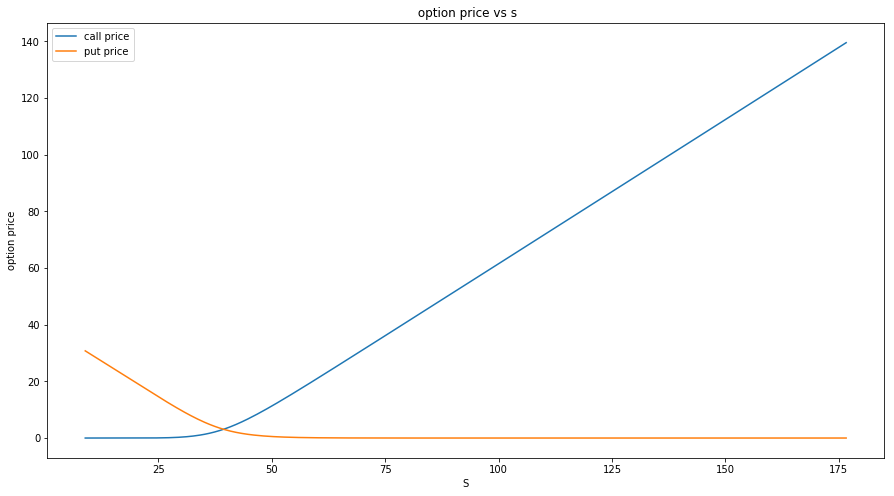

the max putcall error 2.655641998769724


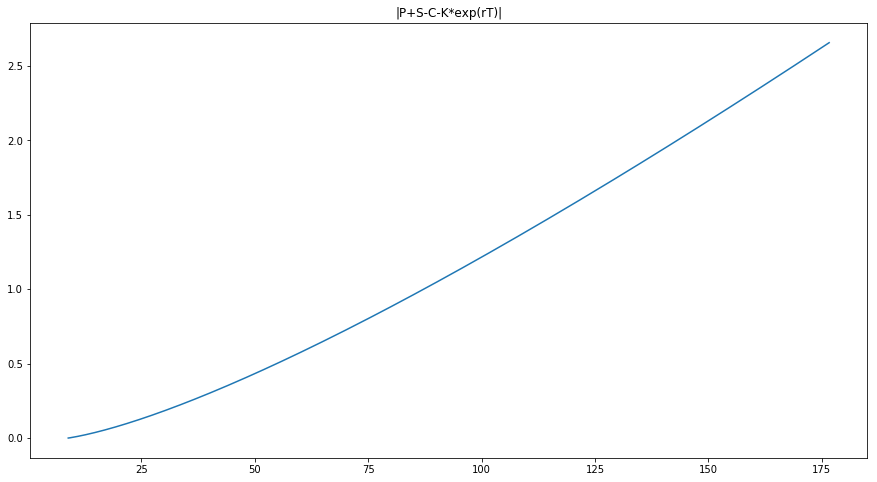

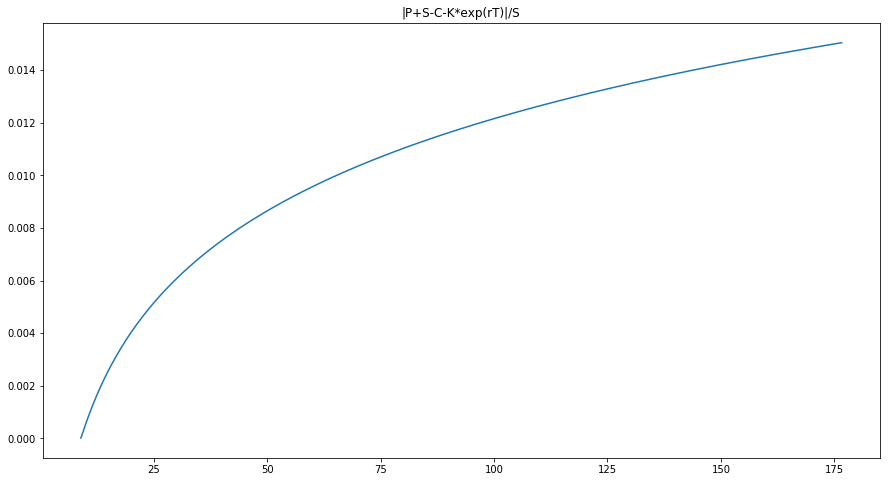

In [33]:
# This is for the fractional PDE and we can see it still holds
# We are going to check it by calculating P+S-C-exp(rt)*K to see if it is close to 0
call_list=fractional_call(200,200,0.03,0.25,0.75,1.5,0.3,40)
put_list=fractional_put(200,200,0.03,0.25,0.75,1.5,0.3,40)
list_len=len(call_list)
x_list=[t*(3/list_len)-1.5 for t in range(list_len)]
s_list=[40*exp(t) for t in x_list]
plt.figure(figsize=(15,8))
plt.title(" option price vs s")
plt.xlabel('S')
plt.ylabel('option price')
plt.plot(s_list,call_list,label='call price')
plt.plot(s_list,put_list,label='put price')
plt.legend(loc='upper left') 
plt.show()


# putcall_parity =  P+S-C-exp(rt)*K 
putcall_parity1=abs(np.array(put_list)+np.array(s_list)-np.array(call_list)-exp(-r*T)*40)
# plt.plot(s_list,put_list,label='put price')
putcall_parity_error=max(abs(putcall_parity1))
print("the max putcall error",putcall_parity_error)

# This is absolute error  
plt.figure(figsize=(15,8))
plt.title('|P+S-C-K*exp(rT)|')
plt.plot(s_list,putcall_parity1)
plt.show()

# This is percentage error (relative to s)
plt.figure(figsize=(15,8))
plt.title('|P+S-C-K*exp(rT)|/S')
plt.plot(s_list,putcall_parity1/np.array(s_list))
plt.show()

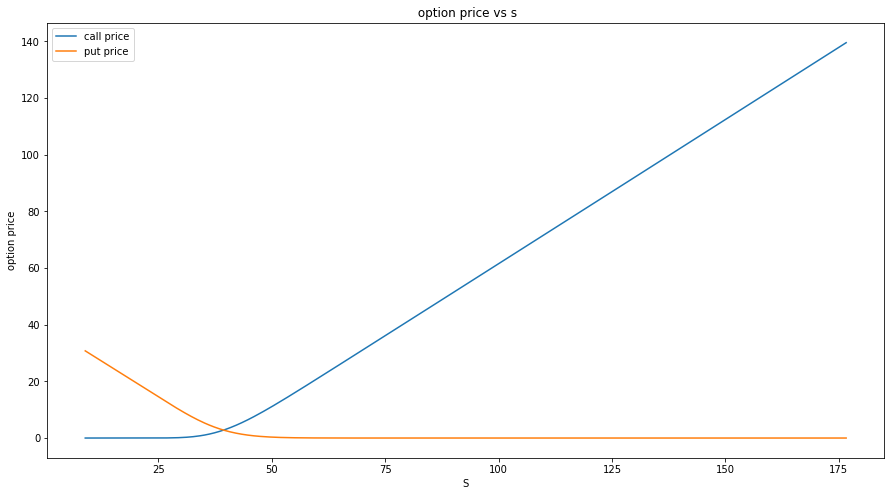

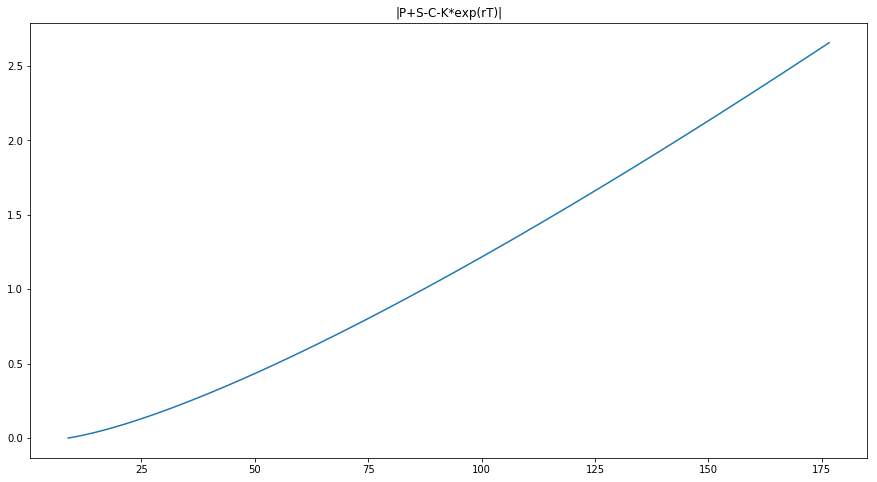

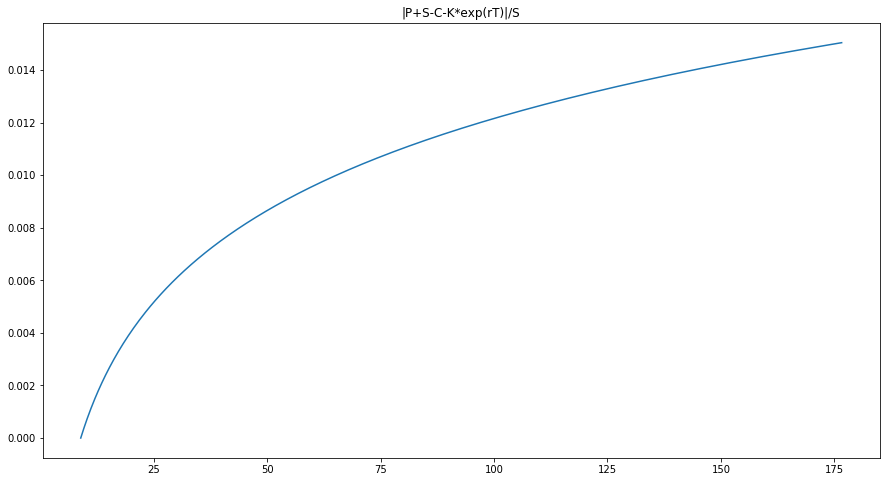

the max putcall error 2.6557668093812907


In [34]:
# This is for the hu_oksendal PDE and we can see it still holds
# We are going to check it by calculating P+S-C-exp(rt)*K to see if it is close to 0
call_list=fdm_be_call(200,200,0.03,0.25,0.75/2,1.5,0.3,40)
put_list=fdm_be_put(200,200,0.03,0.25,0.75/2,1.5,0.3,40)
list_len=len(call_list)
x_list=[t*(3/list_len)-1.5 for t in range(list_len)]
s_list=[40*exp(t) for t in x_list]
plt.figure(figsize=(15,8))
plt.title(" option price vs s")
plt.xlabel('S')
plt.ylabel('option price')
plt.plot(s_list,call_list,label='call price')
plt.plot(s_list,put_list,label='put price')
plt.legend(loc='upper left') 
plt.show()

putcall_parity2=abs(np.array(put_list)+np.array(s_list)-np.array(call_list)-exp(-r*T)*40)
putcall_parity_error=max(putcall_parity2)

# This is absolute error  
plt.figure(figsize=(15,8))
plt.title('|P+S-C-K*exp(rT)|')
plt.plot(s_list,putcall_parity2)
plt.show()

# This is percentage error (relative to s)
plt.figure(figsize=(15,8))
plt.title('|P+S-C-K*exp(rT)|/S')
plt.plot(s_list,putcall_parity2/np.array(s_list))
plt.show()
print("the max putcall error",putcall_parity_error)


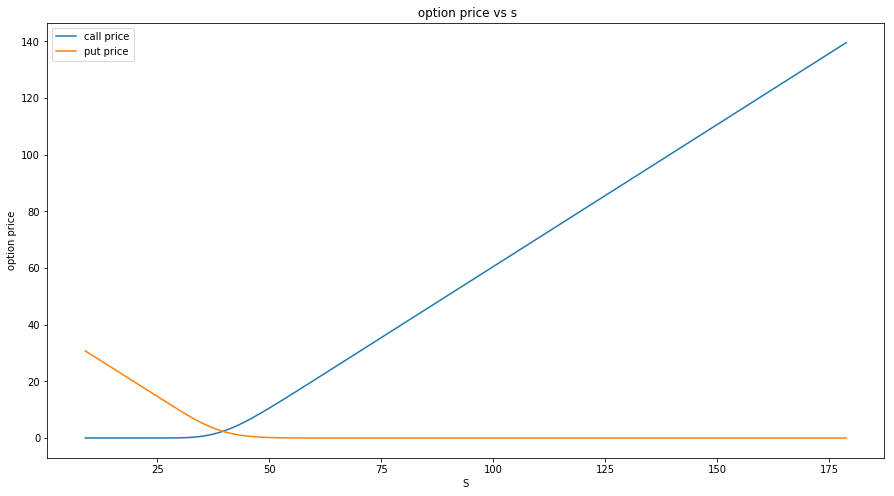

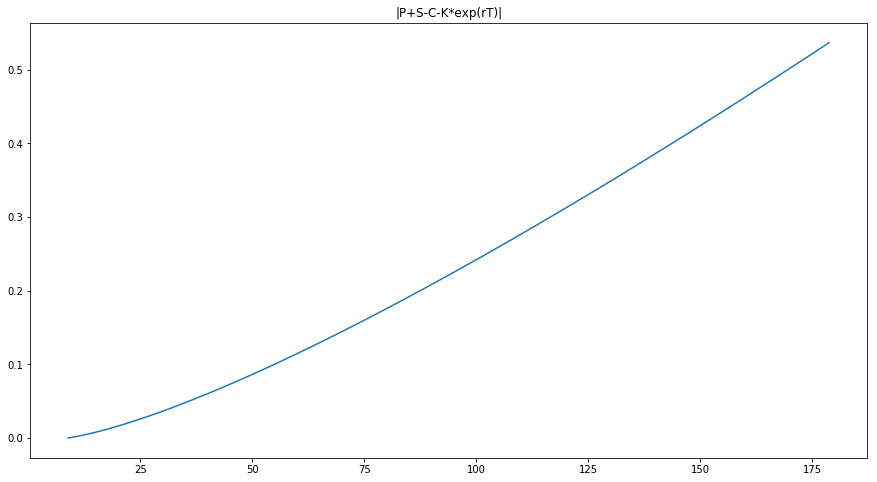

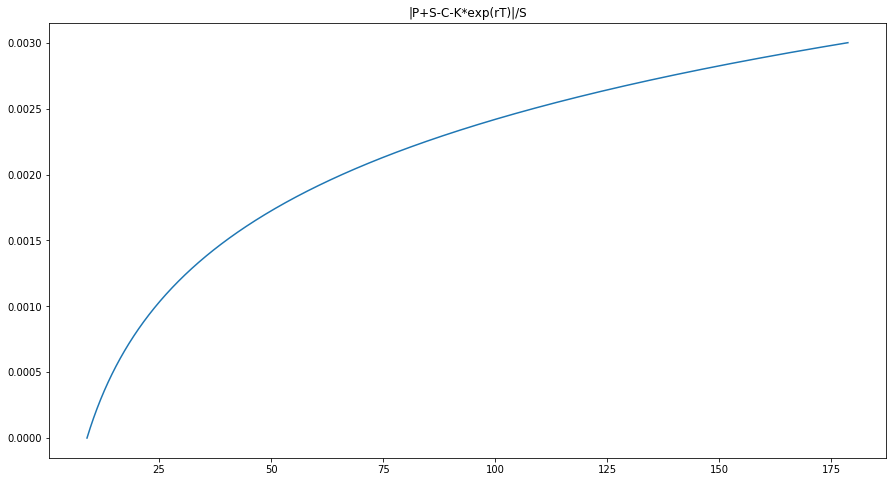

the max putcall error 0.5364611336625131


In [37]:
# This is for the hu_oksendal PDE and we can see it still holds
# This is for standard bm with H=0.5
# We are going to check it by calculating P+S-C-exp(rt)*K to see if it is close to 0
# We increase N and see a decrease in put-call parity error
call_list=fdm_be_call(1000,200,0.03,0.25,0.5,1.5,0.3,40)
put_list=fdm_be_put(1000,200,0.03,0.25,0.5,1.5,0.3,40)
list_len=len(call_list)
x_list=[t*(3/list_len)-1.5 for t in range(list_len)]
s_list=[40*exp(t) for t in x_list]
plt.figure(figsize=(15,8))
plt.title(" option price vs s")
plt.xlabel('S')
plt.ylabel('option price')
plt.plot(s_list,call_list,label='call price')
plt.plot(s_list,put_list,label='put price')
plt.legend(loc='upper left') 
plt.show()

putcall_parity2=abs(np.array(put_list)+np.array(s_list)-np.array(call_list)-exp(-r*T)*40)
putcall_parity_error=max(putcall_parity2)

# This is absolute error  
plt.figure(figsize=(15,8))
plt.title('|P+S-C-K*exp(rT)|')
plt.plot(s_list,putcall_parity2)
plt.show()

# This is percentage error (relative to s)
plt.figure(figsize=(15,8))
plt.title('|P+S-C-K*exp(rT)|/S')
plt.plot(s_list,putcall_parity2/np.array(s_list))
plt.show()
print("the max putcall error",putcall_parity_error)

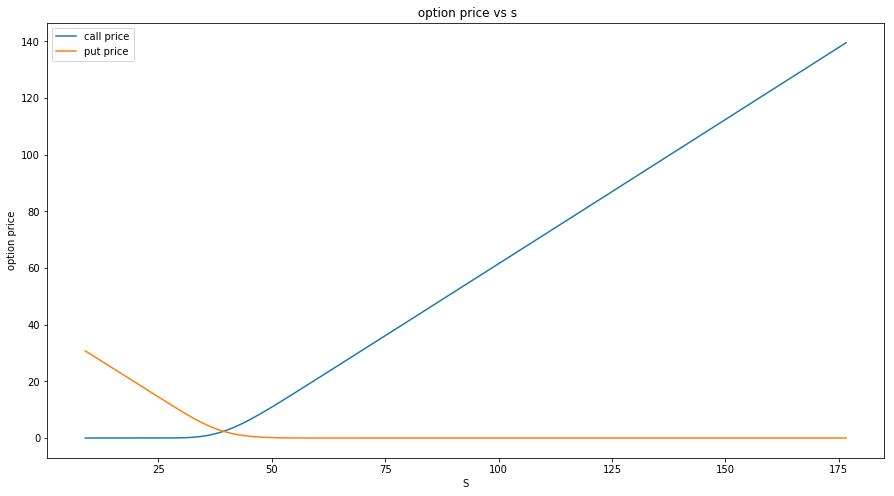

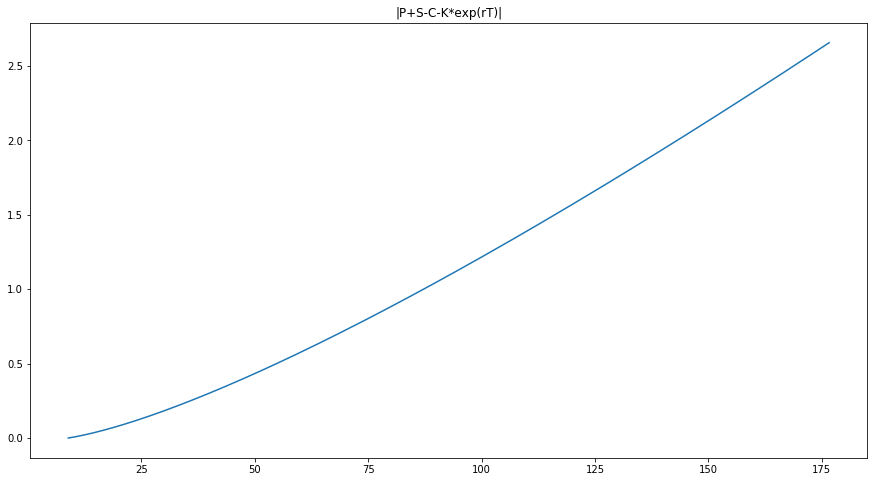

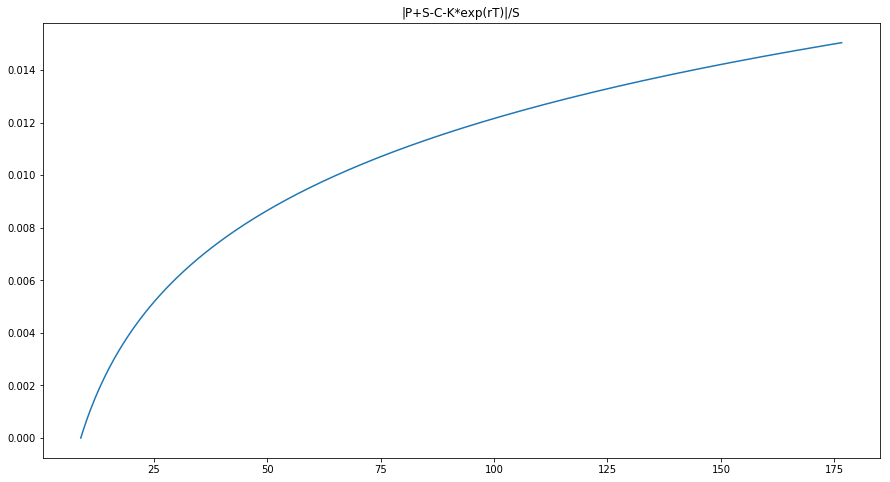

the max putcall error 2.6557668093812907


In [13]:
# Here is the standard BM PDE using put call parity
# H=0.5
# This is for the hu_oksendal PDE and we can see it still holds
# We are going to check it by calculating P+S-C-exp(rt)*K to see if it is close to 0
call_list=fdm_be_call(200,200,0.03,0.25,0.5,1.5,0.3,40)
put_list=fdm_be_put(200,200,0.03,0.25,0.5,1.5,0.3,40)
list_len=len(call_list)
x_list=[t*(3/list_len)-1.5 for t in range(list_len)]
s_list=[40*exp(t) for t in x_list]
plt.figure(figsize=(15,8))
plt.title(" option price vs s")
plt.xlabel('S')
plt.ylabel('option price')
plt.plot(s_list,call_list,label='call price')
plt.plot(s_list,put_list,label='put price')
plt.legend(loc='upper left') 
plt.show()

putcall_parity2=abs(np.array(put_list)+np.array(s_list)-np.array(call_list)-exp(-r*T)*40)
putcall_parity_error=max(putcall_parity2)

# This is absolute error  
plt.figure(figsize=(15,8))
plt.title('|P+S-C-K*exp(rT)|')
plt.plot(s_list,putcall_parity2)
plt.show()

# This is percentage error (relative to s)
plt.figure(figsize=(15,8))
plt.title('|P+S-C-K*exp(rT)|/S')
plt.plot(s_list,putcall_parity2/np.array(s_list))
plt.show()
print("the max putcall error",putcall_parity_error)


When we compare standard BS(SBS) model with fractional BS(FBS), there are not many differences.
In both explicit formulas, the only difference lies in d1, to be more specific, for FBS the sigma = sigma*(T^H)
So when we take the derivative regarding underlying price S, we get almost the same result as that in SBS.(with out dividends)
deltaC = N(d1) and deltaP=N(d1)-1
The following graph proves the result
Also, according to the put-call parity, the delta for the put is N(d1)-1
delta_C-delta_P=1

We use 3 ways to verify it.
1. the explicit formula from hu_oksendal
2. the pde from hu_oksendal:we use the pde to get price and then use numerical approximation to get the derivative (delta)
3. the pde from jumarie: we use the pde to get price and then use numerical approximation to get the derivative (delta)

Then we compare those results with the delta from explicit formula: delta=N(d1), and plot the discrepancy 

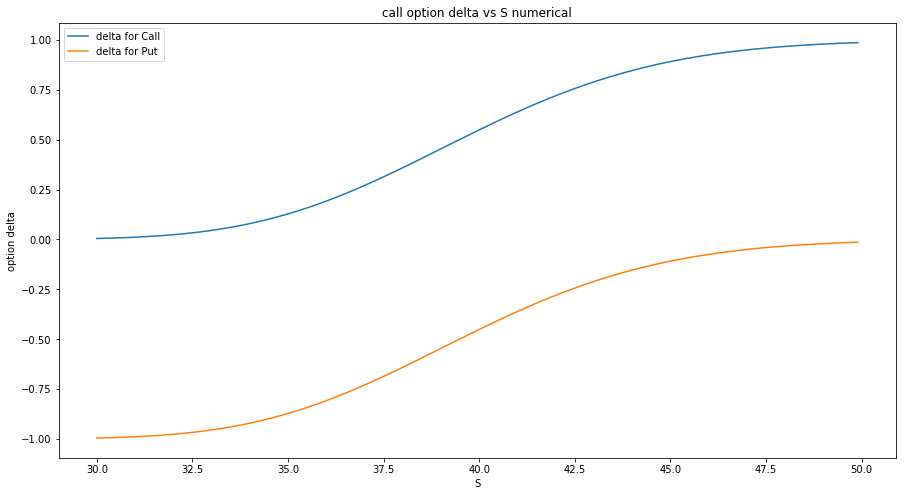

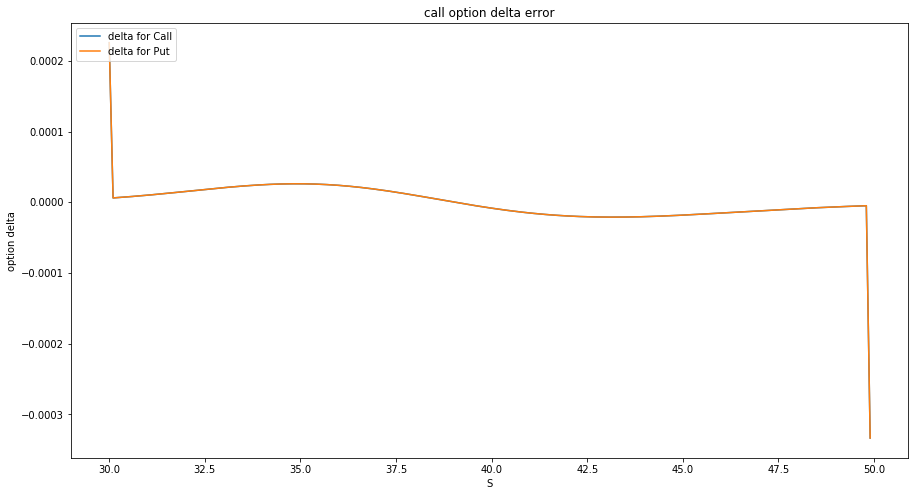

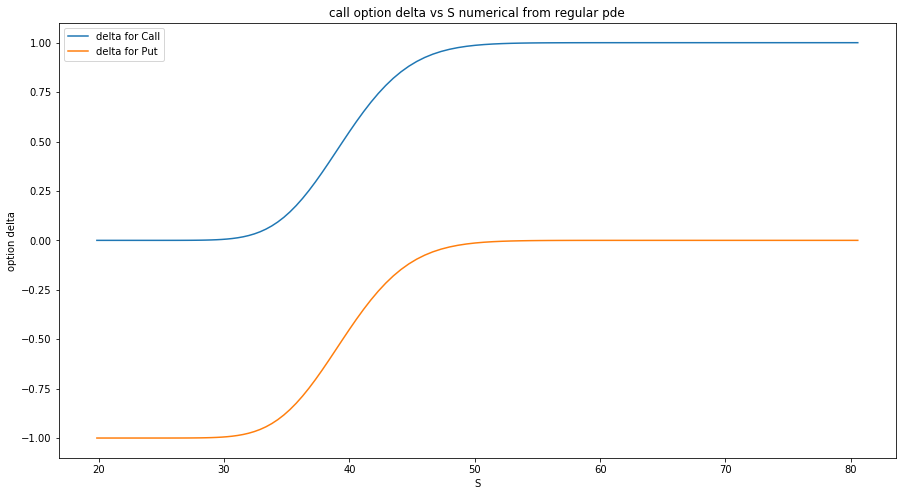

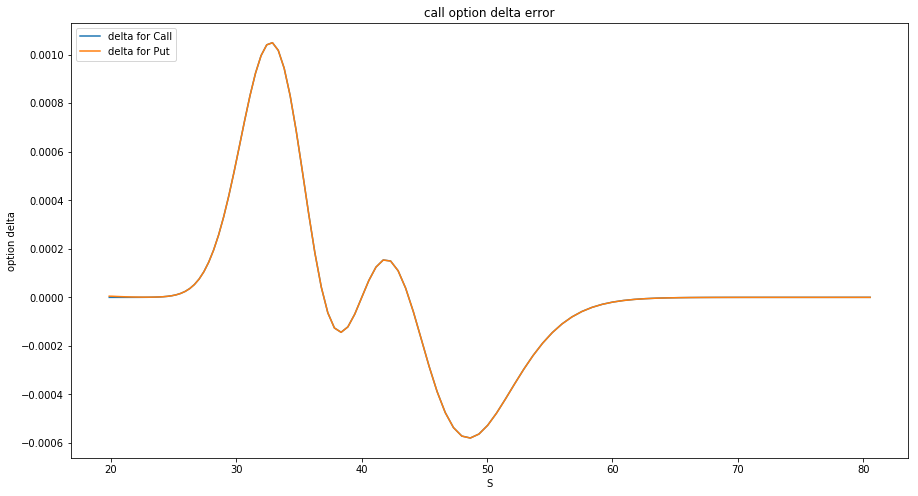

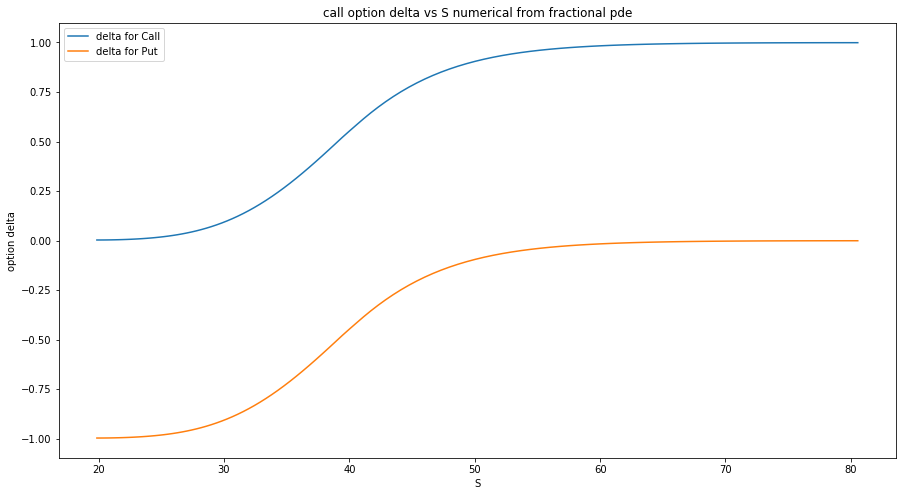

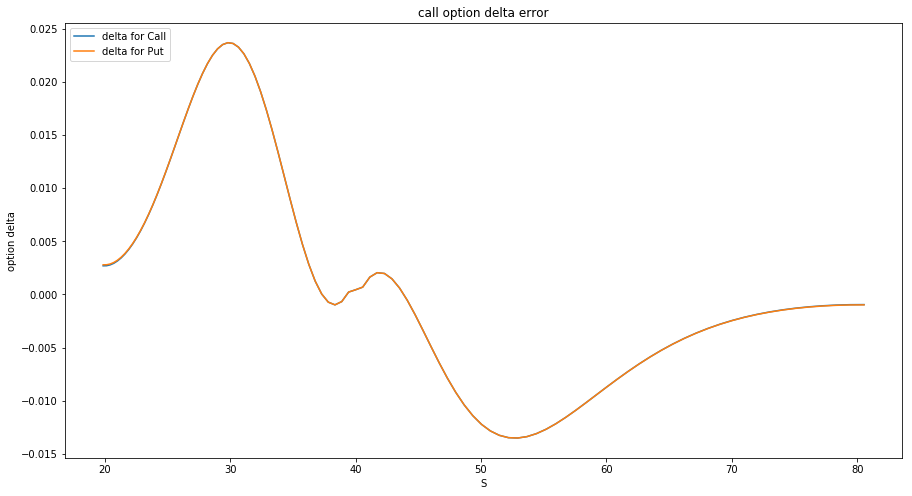

In [26]:
S_list=[S/10 for S in range(300,500)]
# S from 30.0 to 50.0
h=0.1

# This is using explicit formula to get the delta
call_list=[call_option_explicit(r,0.25,0.75,S,sigma,40) for S in S_list]
put_list=[put_option_explicit(r,0.25,0.75,S,sigma,40) for S in S_list]
numerical_deltaCall=[]
numerical_deltaPut=[]
#numerical approximation of delta
for i in range(len(call_list)):
    if i==0:
        numerical_deltaCall+=[(call_list[i+1]-call_list[i])/h]
        numerical_deltaPut+=[(put_list[i+1]-put_list[i])/h]
    elif i==(len(call_list)-1):
        numerical_deltaCall+=[(call_list[i]-call_list[i-1])/h]
        numerical_deltaPut+=[(put_list[i]-put_list[i-1])/h]
    else:
        numerical_deltaCall+=[(call_list[i+1]-call_list[i-1])/(2*h)]
        numerical_deltaPut+=[(put_list[i+1]-put_list[i-1])/(2*h)]
plt.figure(figsize=(15,8))
plt.title("call option delta vs S numerical")
plt.xlabel('S')
plt.ylabel('option delta')
plt.plot(S_list,numerical_deltaCall,label='delta for Call')
plt.plot(S_list,numerical_deltaPut,label='delta for Put')
plt.legend(loc='upper left') 
plt.show()
analytic_deltaCall=[call_delta_explicit(r,0.25,0.75,S,0.3,40) for S in S_list]  
analytic_deltaPut=[put_delta_explicit(r,0.25,0.75,S,0.3,40) for S in S_list] 

#This is to get delta from deltaC = N(d1) and deltaP=N(d1)-1
#analytical approximation of delta
plt.figure(figsize=(15,8))
plt.title("call option delta error")
plt.xlabel('S')
plt.ylabel('option delta')

# Plot the discrepancy between numerical values and analytical values
# The error in calls and puts are very close, so the plot will overlap
plt.plot(S_list,np.array(numerical_deltaCall)-analytic_deltaCall,label='delta for Call')
plt.plot(S_list,np.array(numerical_deltaPut)-analytic_deltaPut,label='delta for Put')
plt.legend(loc='upper left') 
plt.show()

# We can see they are very close

# Here we take xm=0.7
# when xm=-0.7,S/K=exp(xm)=0.5
# when xm=0.7,S/K=exp(xm)=2
# K is fixed, S is stated in K_list according to the value of xm
# This is using regular(hu_oksendal) pde

xm=0.7
N=100
x=np.arange(-xm, xm+xm/N, 2*xm/N)
s_list=40*exp(x)
s_list


call_list=fdm_be_call(100,100,0.03,0.25,0.75,0.7,0.3,40)
put_list=fdm_be_put(100,100,0.03,0.25,0.75,0.7,0.3,40)
numerical_deltaCall=[]
numerical_deltaPut=[]
#numerical approximation of delta
for i in range(len(call_list)):
    if i==0:
        numerical_deltaCall+=[(call_list[i+1]-call_list[i])/(s_list[i+1]-s_list[i])]
        numerical_deltaPut+=[(put_list[i+1]-put_list[i])/(s_list[i+1]-s_list[i])]
    elif i==(len(call_list)-1):
        numerical_deltaCall+=[(call_list[i]-call_list[i-1])/(s_list[i]-s_list[i-1])]
        numerical_deltaPut+=[(put_list[i]-put_list[i-1])/(s_list[i]-s_list[i-1])]
    else:
        numerical_deltaCall+=[(call_list[i+1]-call_list[i-1])/(s_list[i+1]-s_list[i-1])]
        numerical_deltaPut+=[(put_list[i+1]-put_list[i-1])/(s_list[i+1]-s_list[i-1])]
plt.figure(figsize=(15,8))
plt.title("call option delta vs S numerical from regular pde")
plt.xlabel('S')
plt.ylabel('option delta')
plt.plot(s_list,numerical_deltaCall,label='delta for Call')
plt.plot(s_list,numerical_deltaPut,label='delta for Put')
plt.legend(loc='upper left') 
plt.show()
analytic_deltaCall=[call_delta_explicit(r,0.25,0.75,S,0.3,40) for S in s_list]  
analytic_deltaPut=[put_delta_explicit(r,0.25,0.75,S,0.3,40) for S in s_list] 
#analytical approximation of delta
plt.figure(figsize=(15,8))
plt.title("call option delta error")
plt.xlabel('S')
plt.ylabel('option delta')
# Plot the discrepancy between numerical values and analytical values
plt.plot(s_list,np.array(numerical_deltaCall)-analytic_deltaCall,label='delta for Call')
plt.plot(s_list,np.array(numerical_deltaPut)-analytic_deltaPut,label='delta for Put')
plt.legend(loc='upper left') 
plt.show()


# This is using fractional (jumarie) pde
call_list=fractional_call(100,100,0.03,0.25,0.75,0.7,0.3,40)
put_list=fractional_put(100,100,0.03,0.25,0.75,0.7,0.3,40)
numerical_deltaCall=[]
numerical_deltaPut=[]
#numerical approximation of delta
for i in range(len(call_list)):
    if i==0:
        numerical_deltaCall+=[(call_list[i+1]-call_list[i])/(s_list[i+1]-s_list[i])]
        numerical_deltaPut+=[(put_list[i+1]-put_list[i])/(s_list[i+1]-s_list[i])]
    elif i==(len(call_list)-1):
        numerical_deltaCall+=[(call_list[i]-call_list[i-1])/(s_list[i]-s_list[i-1])]
        numerical_deltaPut+=[(put_list[i]-put_list[i-1])/(s_list[i]-s_list[i-1])]
    else:
        numerical_deltaCall+=[(call_list[i+1]-call_list[i-1])/(s_list[i+1]-s_list[i-1])]
        numerical_deltaPut+=[(put_list[i+1]-put_list[i-1])/(s_list[i+1]-s_list[i-1])]
plt.figure(figsize=(15,8))
plt.title("call option delta vs S numerical from fractional pde")
plt.xlabel('S')
plt.ylabel('option delta')
plt.plot(s_list,numerical_deltaCall,label='delta for Call')
plt.plot(s_list,numerical_deltaPut,label='delta for Put')
plt.legend(loc='upper left') 
plt.show()
analytic_deltaCall=[call_delta_explicit(r,0.25,0.75/2,S,0.3,40) for S in s_list]  
analytic_deltaPut=[put_delta_explicit(r,0.25,0.75/2,S,0.3,40) for S in s_list] 
#analytical approximation of delta
plt.figure(figsize=(15,8))
plt.title("call option delta error")
plt.xlabel('S')
plt.ylabel('option delta')

# Plot the discrepancy between numerical values and analytical values

plt.plot(s_list,np.array(numerical_deltaCall)-analytic_deltaCall,label='delta for Call')
plt.plot(s_list,np.array(numerical_deltaPut)-analytic_deltaPut,label='delta for Put')
plt.legend(loc='upper left') 
plt.show()



Here is the implied vol part:
I used secant method to solve for the implied vol. On the left hand side of the equation, I used three methods to calculate the option price. One is explicit formula, one is solving hu_oksendal pde and the other one is solving jumarie's pde to get the price. On the right hand side of the equation, the price of the option is simulated using MC method.

C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


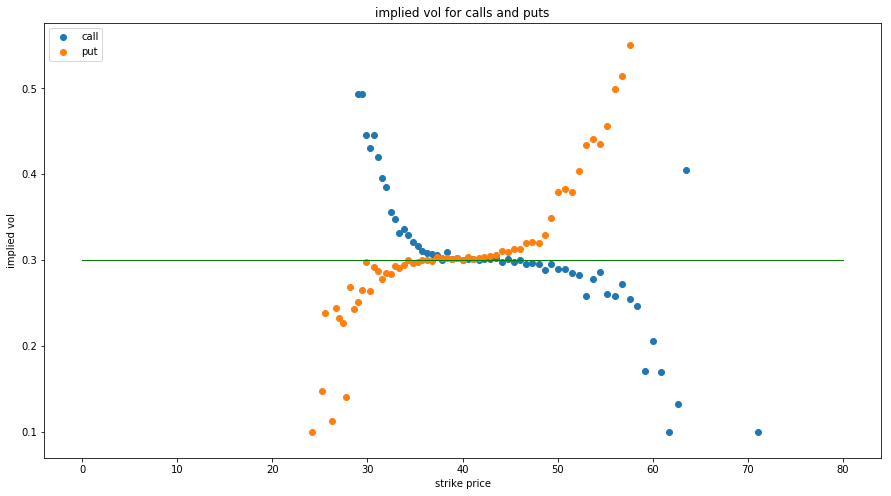

In [14]:
# This is H=0.75 which cannot be used in comparison
# This is using hu_oksendal pde
# Here we take xm=0.7
# when xm=-0.7,S/K=exp(xm)=0.5
# when xm=0.7,S/K=exp(xm)=2
# S is fixed, K is stated in K_list according to the value of xm
# This is for regular pde
xm=0.7
N=100
x=np.arange(-xm, xm+xm/N, 2*xm/N)
K_list=40/exp(x)

call_price_list=MC_simulation_call_list(0.03,0.25,0.75,40,0.3,K_list)
average_MC=call_price_list
for i in range(100000):
    average_MC+=MC_simulation_call_list(0.03,0.25,0.75,40,0.3,K_list)
average_MC=average_MC/100001   
call_price_list=average_MC

put_price_list=MC_simulation_put_list(0.03,0.25,0.75,40,0.3,K_list)
average_MC=put_price_list
for i in range(100000):
    average_MC+=MC_simulation_put_list(0.03,0.25,0.75,40,0.3,K_list)
average_MC=average_MC/100001   
put_price_list=average_MC

call_sigma_list=[]
K_call_list=[]
put_sigma_list=[]
K_put_list=[]

for i in range(len(K_list)):
    try:
        
#         print(call_vol_solver_pde(100,100,0.03,0.25,0.75,1.5,K_list[i],call_price_list[i],i))
#         print(K_list[i],call_price_list[i])
        sigma=call_vol_solver_pde(100,100,0.03,0.25,0.75,0.7,K_list[i],call_price_list[i],i)
#         print(i)
        if sigma>0 and sigma!=0.1 and sigma<1:
            call_sigma_list+=[sigma]
            K_call_list+=[K_list[i]]
#             print('success',i)
    except:
#         print('e',i)
        pass


for i in range(len(K_list)):
    try:
        
#         print(call_vol_solver_pde(100,100,0.03,0.25,0.75,1.5,K_list[i],call_price_list[i],i))
#         print(K_list[i],put_price_list[i])
        sigma=put_vol_solver_pde(100,100,0.03,0.25,0.75,0.7,K_list[i],put_price_list[i],i)
#         print(i)
        if sigma>0 and sigma!=0.1 and sigma<1:
            put_sigma_list+=[sigma]
            K_put_list+=[K_list[i]]
#             print('success',i)
    except:
#         print('e',i)
        pass
plt.figure(figsize=(15,8))
plt.title("implied vol for calls and puts")
plt.xlabel('strike price')
plt.ylabel('implied vol')    
plt.scatter(K_call_list,call_sigma_list,label="call")
plt.scatter(K_put_list,put_sigma_list,label='put')
plt.legend(loc='upper left') 
plt.plot([0, 80],[0.3, 0.3], 'k-', lw=1,c='g')
plt.show()

call_sigma_list1=call_sigma_list
put_sigma_list1=put_sigma_list
K_call_list1=K_call_list
K_put_list1=K_put_list

C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
C:\Software\PythonAnaconda\envs\py3

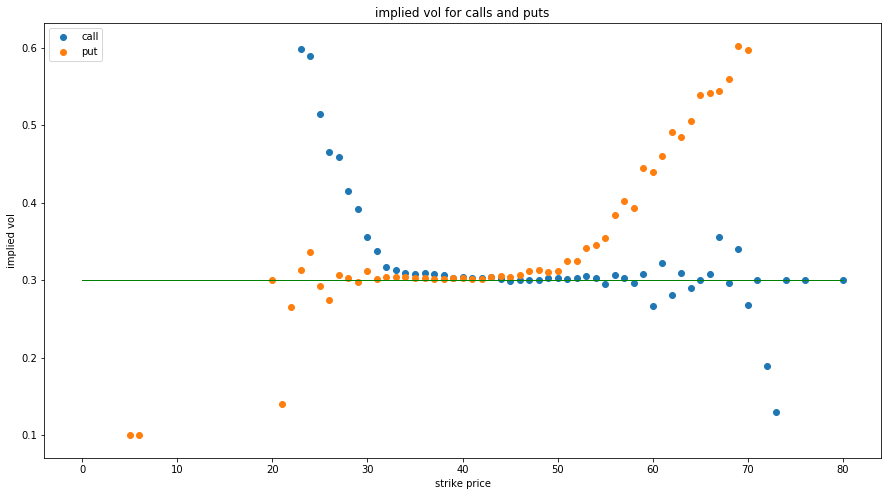

In [38]:
# This is using hu_oksendal's explicit formula

# generate 100000 call option price paths with different strikes then average them  

K1=1
K2=80
n=80

K_list=[K1+i/(n-1)*(K2-K1) for i in range(n)][::-1]

average_MC=MC_simulation_call(0.03,0.25,0.99/2,40,0.3,K1,K2,n)
for i in range(100000):
    average_MC+=MC_simulation_call(0.03,0.25,0.99/2,40,0.3,K1,K2,n)
average_MC=average_MC/100001
call_price_list=average_MC

# generate 100000 put option price paths with different strikes then average them  

put_sigma_list=[]
K_put_list=[]
average_MC=MC_simulation_put(0.03,0.25,0.99/2,40,0.3,K1,K2,n)
for i in range(100000):
    average_MC+=MC_simulation_put(0.03,0.25,0.99/2,40,0.3,K1,K2,n)
average_MC=average_MC/100001

put_price_list=average_MC


# using explicit fbm formula from hu_oksendal to solve for implied vol, for some bad prices, I just ignore it and move on to the next price, 
# so the plot may look inconsistent, but the shape in general is clear
call_sigma_list=[]
K_call_list=[]
put_sigma_list=[]
K_put_list=[]
for i in range(80):
    try:
#         
#         print(K_list[i],call_price_list[i])
        sigma=call_vol_solver_explicit(100,100,0.03,0.25,0.99/2,40,K_list[i],call_price_list[i])
#         print(i)
        if sigma!=-1:
            if sigma>0.1 and sigma<1:
                call_sigma_list+=[sigma]
                K_call_list+=[K_list[i]]
    except:
#         print('e',i)
        pass

plt.figure(figsize=(15,8))
plt.title("implied vol for calls and puts")
plt.xlabel('strike price')
plt.ylabel('implied vol')    
plt.scatter(K_call_list,call_sigma_list,label="call")
# plt.show()

for i in range(80):
    try:
#         
#         print(K_list[i],call_price_list[i])
        sigma=put_vol_solver_explicit(100,100,0.03,0.25,0.99/2,40,K_list[i],put_price_list[i])
#         print(i)
        if sigma!=-1:
            if sigma>0.1 and sigma<1:
                put_sigma_list+=[sigma]
                K_put_list+=[K_list[i]]
    except:
#         print('e',i)
        pass

# plt.figure(figsize=(15,8))    
plt.scatter(K_put_list,put_sigma_list,label='put')
plt.legend(loc='upper left') 
plt.plot([0, 80],[0.3, 0.3], 'k-', lw=1,c='g')
plt.show()
call_sigma_list1=call_sigma_list
put_sigma_list1=put_sigma_list
K_call_list1=K_call_list
K_put_list1=K_put_list


C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


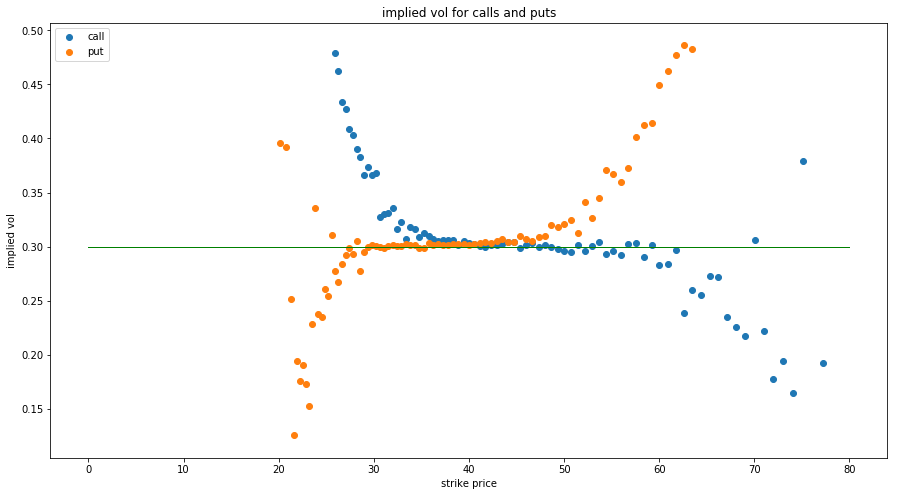

In [39]:
# This is using hu_oksendal pde
# Here we take xm=0.7
# when xm=-0.7,S/K=exp(xm)=0.5
# when xm=0.7,S/K=exp(xm)=2
# S is fixed, K is stated in K_list according to the value of xm
# This is for regular pde
# Let's put H=0.75/2 to see if the implied vol is the same
xm=0.7
N=100
x=np.arange(-xm, xm+xm/N, 2*xm/N)
K_list=40/exp(x)

call_price_list=MC_simulation_call_list(0.03,0.25,0.99/2,40,0.3,K_list)
average_MC=call_price_list
for i in range(100000):
    average_MC+=MC_simulation_call_list(0.03,0.25,0.99/2,40,0.3,K_list)
average_MC=average_MC/100001   
call_price_list=average_MC

put_price_list=MC_simulation_put_list(0.03,0.25,0.99/2,40,0.3,K_list)
average_MC=put_price_list
for i in range(100000):
    average_MC+=MC_simulation_put_list(0.03,0.25,0.99/2,40,0.3,K_list)
average_MC=average_MC/100001   
put_price_list=average_MC

call_sigma_list=[]
K_call_list=[]
put_sigma_list=[]
K_put_list=[]

for i in range(len(K_list)):
    try:
        
#         print(call_vol_solver_pde(100,100,0.03,0.25,0.75,1.5,K_list[i],call_price_list[i],i))
#         print(K_list[i],call_price_list[i])
        sigma=call_vol_solver_pde(100,100,0.03,0.25,0.99/2,0.7,K_list[i],call_price_list[i],i)
#         print(i)
        if sigma>0 and sigma!=0.1 and sigma<1:
            call_sigma_list+=[sigma]
            K_call_list+=[K_list[i]]
#             print('success',i)
    except:
#         print('e',i)
        pass


for i in range(len(K_list)):
    try:
        
#         print(call_vol_solver_pde(100,100,0.03,0.25,0.75,1.5,K_list[i],call_price_list[i],i))
#         print(K_list[i],put_price_list[i])
        sigma=put_vol_solver_pde(100,100,0.03,0.25,0.99/2,0.7,K_list[i],put_price_list[i],i)
#         print(i)
        if sigma>0 and sigma!=0.1 and sigma<1:
            put_sigma_list+=[sigma]
            K_put_list+=[K_list[i]]
#             print('success',i)
    except:
#         print('e',i)
        pass
plt.figure(figsize=(15,8))
plt.title("implied vol for calls and puts")
plt.xlabel('strike price')
plt.ylabel('implied vol')    
plt.scatter(K_call_list,call_sigma_list,label="call")
plt.scatter(K_put_list,put_sigma_list,label='put')
plt.legend(loc='upper left') 
plt.plot([0, 80],[0.3, 0.3], 'k-', lw=1,c='g')
plt.show()

call_sigma_list2=call_sigma_list
put_sigma_list2=put_sigma_list
K_call_list2=K_call_list
K_put_list2=K_put_list

C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in double_scalars
C:\Software\PythonAnaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in doub

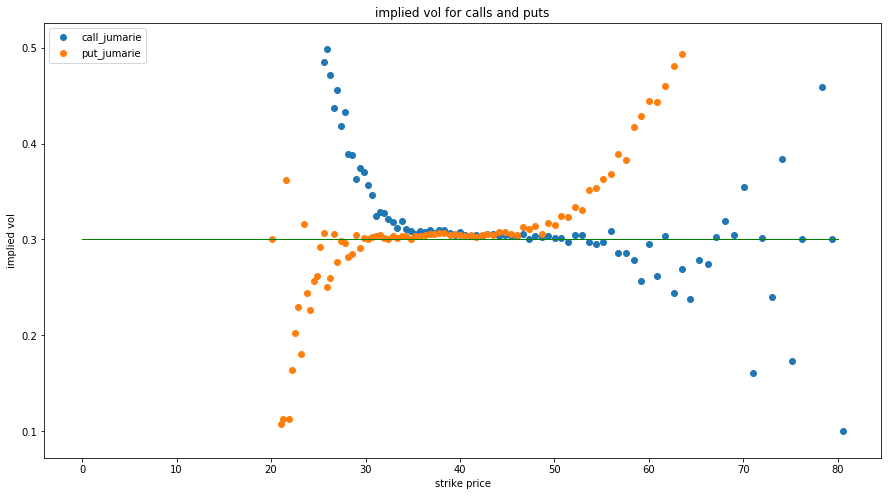

In [37]:
# This is using jumarie's(fractional) pde
# NOTE here in the simulation function, H=alpha/2
# We take alpha=0.75
# H=0.75/2
# Here we take xm=0.7
# when xm=-0.7,S/K=exp(xm)=0.5
# when xm=0.7,S/K=exp(xm)=2
# S is fixed, K is stated in K_list according to the value of xm

xm = 0.7
N = 100
x = np.arange(-xm, xm + xm / N, 2 * xm / N)
K_list = 40 / exp(x)

call_price_list = MC_simulation_call_list(0.03, 0.25, 0.99 / 2, 40, 0.3, K_list)
average_MC = call_price_list
for i in range(100000):
    average_MC += MC_simulation_call_list(0.03, 0.25, 0.99 / 2, 40, 0.3, K_list)
average_MC = average_MC / 100001
call_price_list = average_MC

put_price_list = MC_simulation_put_list(0.03, 0.25, 0.99 / 2, 40, 0.3, K_list)
average_MC = put_price_list
for i in range(100000):
    average_MC += MC_simulation_put_list(0.03, 0.25, 0.99 / 2, 40, 0.3, K_list)
average_MC = average_MC / 100001
put_price_list = average_MC

call_sigma_list = []
K_call_list = []
put_sigma_list = []
K_put_list = []

for i in range(len(K_list)):
    try:

        #         print(call_vol_solver_pde(100,100,0.03,0.25,0.75,1.5,K_list[i],call_price_list[i],i))
        #         print(K_list[i],call_price_list[i])
        sigma = call_vol_solver_fpde(100, 100, 0.03, 0.25, 0.99, 0.7, K_list[i], call_price_list[i], i)
        #         print(i)
        if sigma > 0 and sigma != 0.1 and sigma < 1:
            call_sigma_list += [sigma]
            K_call_list += [K_list[i]]
            #             print('success',i)
    except:
        #         print('e',i)
        pass

for i in range(len(K_list)):
    try:

        #         print(call_vol_solver_pde(100,100,0.03,0.25,0.75,1.5,K_list[i],call_price_list[i],i))
        #         print(K_list[i],put_price_list[i])
        sigma = put_vol_solver_fpde(100, 100, 0.03, 0.25, 0.99, 0.7, K_list[i], put_price_list[i], i)
        #         print(i)
        if sigma > 0 and sigma != 0.1 and sigma < 1:
            put_sigma_list += [sigma]
            K_put_list += [K_list[i]]
            #             print('success',i)
    except:
        #         print('e',i)
        pass
plt.figure(figsize=(15, 8))
plt.title("implied vol for calls and puts")
plt.xlabel('strike price')
plt.ylabel('implied vol')
plt.scatter(K_call_list, call_sigma_list, label="call_jumarie")
plt.scatter(K_put_list, put_sigma_list, label='put_jumarie')
plt.legend(loc='upper left')
plt.plot([0, 80], [0.3, 0.3], 'k-', lw=1, c='g')
plt.show()
call_sigma_list3=call_sigma_list
put_sigma_list3=put_sigma_list
K_call_list3=K_call_list
K_put_list3=K_put_list

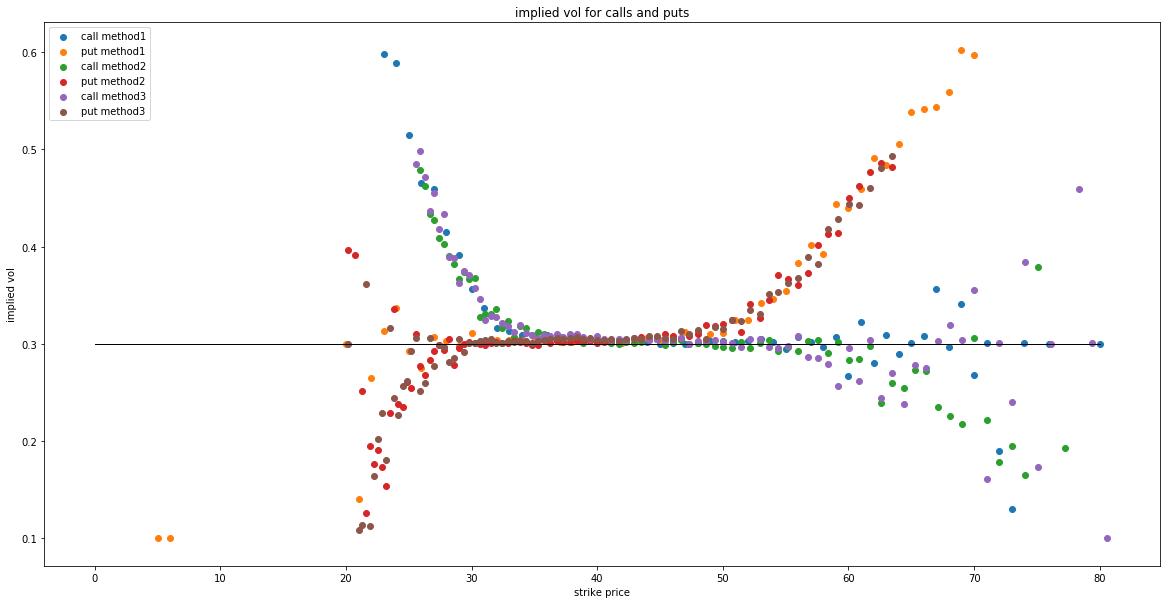

In [40]:
plt.figure(figsize=(20,10))
plt.title("implied vol for calls and puts")
plt.xlabel('strike price')
plt.ylabel('implied vol')
plt.scatter(K_call_list1,call_sigma_list1,label="call method1")
plt.scatter(K_put_list1,put_sigma_list1,label='put method1')
plt.scatter(K_call_list2,call_sigma_list2,label="call method2")
plt.scatter(K_put_list2,put_sigma_list2,label='put method2')
plt.scatter(K_call_list3,call_sigma_list3,label="call method3")
plt.scatter(K_put_list3,put_sigma_list3,label='put method3')
plt.legend(loc='upper left') 
plt.plot([0, 80],[0.3, 0.3], 'k-', lw=1,c='k')
plt.show()
